In [1]:
import numpy as np
import sys

import matplotlib.pylab as plt
import seaborn as sns
import scipy.misc
import cv2

sys.path.insert(0, "../src/")
import constants as c
import batch_generator as bg

In [2]:
import imgaug as ia
from imgaug import augmenters as iaa
import numpy as np

# random example images
images = np.random.randint(0, 255, (16, 128, 128, 3), dtype=np.uint8)

# Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
# e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second image.
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

# Define our sequence of augmentation steps that will be applied to every image
# All augmenters with per_channel=0.5 will sample one value _per image_
# in 50% of all cases. In all other cases they will sample new values
# _per channel_.
seq = iaa.Sequential(
    [
            sometimes(iaa.Affine(
            mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        iaa.SomeOf((0, 5),
            [
                sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                    iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                    iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
                ]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                # search either for all edges or for directed edges
                sometimes(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0, 0.7)),
                    iaa.DirectedEdgeDetect(alpha=(0, 0.7), direction=(0.0, 1.0)),
                ])),
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                    iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                ]),
                iaa.Invert(0.05, per_channel=True), # invert color channels
                iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                iaa.Multiply((0.5, 1.5), per_channel=0.5), # change brightness of images (50-150% of original value)
                iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
                iaa.Grayscale(alpha=(0.0, 1.0)),
                sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
            ],
            random_order=True
        )
    ],
    random_order=True
)

images_aug = seq.augment_images(images)

(5, 96, 96, 3)


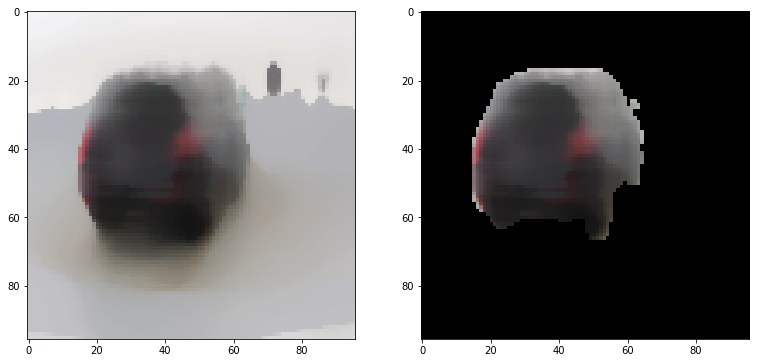

error: /io/opencv/modules/imgproc/src/color.cpp:10600: error: (-215) depth == CV_8U || depth == CV_16U || depth == CV_32F in function cvtColor


In [3]:
batch_gen = bg.CarvanaBatchGenerator('train', 4, dims_area=(96,96))

for batch_idx in range(1000):
    # 'images' should be either a 4D numpy array of shape (N, height, width, channels)
    # or a list of 3D numpy arrays, each having shape (height, width, channels).
    # Grayscale images must have shape (height, width, 1) each.
    # All images must have numpy's dtype uint8. Values are expected to be in
    # range 0-255.
    images = batch_gen.get_batches().next()
    images_aug = seq.augment_images(np.uint8(images[0]*255.0))
    print images_aug.shape
    
    img_masked = cv2.bitwise_and(np.uint8(images_aug[0,:]),
                                 np.uint8(images_aug[0,:]),
                                 mask = np.uint8(images[1][0,:]*255.0))
    plt.figure(figsize=(20, 20))
    plt.subplot(131)
    plt.imshow(images_aug[0,:])
    plt.subplot(132)
    plt.imshow(img_masked)

    plt.show()